In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages


plt.rcParams['font.size'] = 14.0
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['axes.titleweight'] = 'bold'

In [2]:
# List to store all DataFrames
dfs = []

folder_path = '../results/round_metrics'

# Loop through all files in the folder
for file in os.listdir(folder_path):
    if file.endswith('.csv'):  # Ensure it's a CSV file
        file_path = os.path.join(folder_path, file)
        # Load the CSV file into a DataFrame and append it to the list
        dfs.append(pd.read_csv(file_path, index_col=0))

In [3]:
df =  pd.concat(dfs, ignore_index=True)

In [4]:
df['accuracy'] = 100 * df['accuracy'].round(4)
df['f1'] = 100 * df['f1'].round(4)

In [5]:
df['server_opt_lr_log10'] = np.log10(df['server_opt_lr']).round(1)
df['client_opt_lr_log10'] = np.log10(df['client_opt_lr']).round(1)

In [6]:
def filter_unique_test(df, checkpoint, ds_path, ds_name, alpha, batch_size, num_clients, clients_per_round, fda):
    return df[
        (df['checkpoint'] == checkpoint) &
        (df['ds_path'] == ds_path) &
        (df['ds_name'] == ds_name) &
        (df['alpha'] == alpha) &
        (df['batch_size'] == batch_size) &
        (df['num_clients'] == num_clients) &
        (df['clients_per_round'] == clients_per_round) &
        (df['fda'] == fda)
    ]

In [7]:
def filter_fed_opt(df, algo, **extra):
    if algo == 'FedAdam':
        return df[
            (df['server_opt_name'] == 'Adam') &
            (df['client_opt_name'] == 'SGD')
        ]
    if algo == 'FedAvg':
        return df[
            (df['server_opt_name'] == 'SGD') &
            (df['client_opt_name'] == 'SGD') &
            (df['server_opt_momentum'].isna())
        ]
    if algo =='FedYogi':
        return df[
            (df['server_opt_name'] == 'Yogi') &
            (df['client_opt_name'] == 'SGD')
        ]
    if algo == 'FedAvgM':
        return df[
            (df['server_opt_name'] == 'SGD') &
            (df['client_opt_name'] == 'SGD') &
            (df['server_opt_momentum'] == extra['server_opt_momentum'])
        ]
    if algo == 'FedAdagrad':
        return df[
            (df['server_opt_name'] == 'Adagrad') &
            (df['client_opt_name'] == 'SGD')
        ]
    if algo == 'FedAdamW':
        return df[
            (df['server_opt_name'] == 'AdamW') &
            (df['client_opt_name'] == 'SGD')
        ]

In [8]:
def learning_rate_grid(df, algo, round_num, ds_name, **extras):
    
    df_algo = filter_fed_opt(df, algo, **extras)
    df_algo_round = df_algo[df_algo['round'] == round_num]
    
    # Pivot the DataFrame for easier plotting
    pivot_table = df_algo_round.pivot(index='client_opt_lr_log10', columns='server_opt_lr_log10', values='accuracy')

    # Extract unique learning rates and accuracy values
    client_opt_lr = pivot_table.index.astype(float)
    server_opt_lr = pivot_table.columns.astype(float)
    accuracy = pivot_table.values



    # Compute grid edges (midpoints)
    client_opt_lr_edges = []
    server_opt_lr_edges = []

    for axes_val in client_opt_lr:
        client_opt_lr_edges.append(axes_val - 0.5)
        client_opt_lr_edges.append(axes_val + 0.5)

    for axes_val in server_opt_lr:
        server_opt_lr_edges.append(axes_val - 0.5)
        server_opt_lr_edges.append(axes_val + 0.5)

    client_opt_lr_edges = sorted(list(set(client_opt_lr_edges)))
    server_opt_lr_edges = sorted(list(set(server_opt_lr_edges)))
    
    pdf = PdfPages(f'plots/{ds_name}_{algo}_{round_num}.pdf')

    # Create the plot
    plt.figure(figsize=(7.5, 7))
    #plt.figure(figsize=(6, 5))
    #plt.figure(figsize=(8, 6))

    # Add accuracy numbers inside the boxes
    for i in range(len(client_opt_lr)):
        for j in range(len(server_opt_lr)):
            plt.text(
                server_opt_lr[j],  # X-coordinate (server learning rate)
                client_opt_lr[i],  # Y-coordinate (client learning rate)
                f"{accuracy[i, j]:.1f}",  # Format the accuracy to 2 decimal places
                ha='center', va='center', color='black', fontsize=20  # Center the text and use a contrasting color
            )

    # Use pcolormesh with the adjusted edges
    mesh = plt.pcolormesh(
        server_opt_lr_edges,  # Server learning rate edges
        client_opt_lr_edges,  # Client learning rate edges
        accuracy,             # Accuracy values
        cmap='Blues',
        vmin=30,
        vmax=90
    )


    # Add color bar
    cbar = plt.colorbar(mesh)
    cbar.set_label('Accuracy')

    # Label the axes
    plt.xlabel('Server Learning Rate ($\log_{10}$)')
    plt.ylabel('Client Learning Rate ($\log_{10}$)')
    plt.title(f'{ds_name}, {algo}')
    
    plt.xticks(server_opt_lr)
    plt.yticks(client_opt_lr)

    # Show the plot
    #plt.show()
    
    pdf.savefig(plt.gcf()) # Save the current figure
    plt.close()
    pdf.close()

In [38]:
def learning_rate_grid_max(df, algo, round_num, ds_name, **extras):
    
    df_algo = filter_fed_opt(df, algo, **extras)
    
    
    # Group by the specified columns and use a custom aggregation to find the first max based on smallest 'round'
    df_algo_round = (
        df_algo.sort_values(['accuracy', 'round'], ascending=[False, True])  # Sort by accuracy descending, then round ascending
        .groupby(['client_opt_lr_log10', 'server_opt_lr_log10'], as_index=False)
        .first()  # Select the first row in each group
    )
    #print(df_algo_round)
    
    
    # Pivot the DataFrame for easier plotting
    pivot_table = df_algo_round.pivot(index='client_opt_lr_log10', columns='server_opt_lr_log10', values='accuracy')

    # Extract unique learning rates and accuracy values
    client_opt_lr = pivot_table.index.astype(float)
    server_opt_lr = pivot_table.columns.astype(float)
    accuracy = pivot_table.values



    # Compute grid edges (midpoints)
    client_opt_lr_edges = []
    server_opt_lr_edges = []

    for axes_val in client_opt_lr:
        client_opt_lr_edges.append(axes_val - 0.5)
        client_opt_lr_edges.append(axes_val + 0.5)

    for axes_val in server_opt_lr:
        server_opt_lr_edges.append(axes_val - 0.5)
        server_opt_lr_edges.append(axes_val + 0.5)

    client_opt_lr_edges = sorted(list(set(client_opt_lr_edges)))
    server_opt_lr_edges = sorted(list(set(server_opt_lr_edges)))
    
    pdf = PdfPages(f'plots/max_{ds_name}_{algo}_{round_num}.pdf')

    # Create the plot
    plt.figure(figsize=(7.5, 7))
    #plt.figure(figsize=(6, 5))
    #plt.figure(figsize=(8, 6))

    # Add accuracy numbers inside the boxes
    for i in range(len(client_opt_lr)):
        for j in range(len(server_opt_lr)):
            plt.text(
                server_opt_lr[j],  # X-coordinate (server learning rate)
                client_opt_lr[i],  # Y-coordinate (client learning rate)
                f"{accuracy[i, j]:.1f}",  # Format the accuracy to 2 decimal places
                ha='center', va='center', color='black', fontsize=20  # Center the text and use a contrasting color
            )

    # Use pcolormesh with the adjusted edges
    mesh = plt.pcolormesh(
        server_opt_lr_edges,  # Server learning rate edges
        client_opt_lr_edges,  # Client learning rate edges
        accuracy,             # Accuracy values
        cmap='Blues',
        vmin=30,
        vmax=90
    )


    # Add color bar
    cbar = plt.colorbar(mesh)
    cbar.set_label('Accuracy')

    # Label the axes
    plt.xlabel('Server Learning Rate ($\log_{10}$)')
    plt.ylabel('Client Learning Rate ($\log_{10}$)')
    plt.title(f'{ds_name}, {algo}')
    
    plt.xticks(server_opt_lr)
    plt.yticks(client_opt_lr)

    # Show the plot
    #plt.show()
    
    pdf.savefig(plt.gcf()) # Save the current figure
    plt.close()
    pdf.close()

## MRPC

In [39]:
df_mrpc = filter_unique_test(
    df, checkpoint='roberta-base', ds_path='glue', ds_name='mrpc', alpha=1., batch_size=8, num_clients=10, clients_per_round=10, fda=False
)

In [40]:
learning_rate_grid(df_mrpc, 'FedAvgM', round_num=100, ds_name='MRPC', server_opt_momentum=0.9)
learning_rate_grid_max(df_mrpc, 'FedAvgM', round_num=100, ds_name='MRPC', server_opt_momentum=0.9)

In [41]:
learning_rate_grid(df, 'FedAdam', round_num=100, ds_name='MRPC')
learning_rate_grid_max(df, 'FedAdam', round_num=100, ds_name='MRPC')

In [42]:
learning_rate_grid(df, 'FedAdamW', round_num=100, ds_name='MRPC')
learning_rate_grid_max(df, 'FedAdamW', round_num=100, ds_name='MRPC')

ValueError: For X (0) and Y (0) with flat shading, A should have shape (-1, -1, 3) or (-1, -1, 4) or (-1, -1) or (1,), not (0, 0)

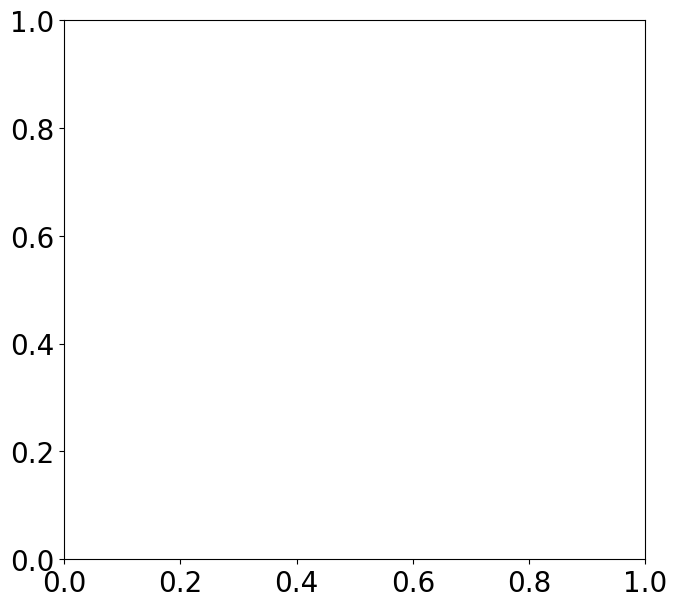

In [13]:
learning_rate_grid(df, 'FedAvg', round_num=100, ds_name='MRPC')

In [34]:
df_adam = filter_fed_opt(df, 'FedAdam')

In [35]:
df_adam['client_opt_lr_log10'].unique()

array([-4., -5., -1., -2., -3.])

In [37]:
df_adam['server_opt_lr_log10'].unique()

array([-2., -4., -1., -5., -3.])

## Variance

In [ ]:
def plot_variance(df, log, algo):
    df = df[df['round'] <= 100]
    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.plot(df['round'], df['variance'], marker='o', linestyle='-', label='Variance')

    # Add grid
    plt.grid(True, linestyle='--', alpha=0.6)

    # Label the axes
    plt.xlabel('Round')
    plt.ylabel('Variance')
    
    if log: plt.yscale('log')

    # Add a title
    plt.title(algo)

    # Add a legend
    plt.legend()

    plt.show()
    
    print(df['variance'].describe())

## FedAdam

In [14]:
df_adam = filter_fed_opt(df, 'FedAdam')
df_adam = df_adam[(df_adam['server_opt_lr_log10'] == -4) & (df_adam['client_opt_lr_log10'] == -4)]

In [15]:
plot_variance(df_adam, True, 'FedAdam')

NameError: name 'plot_variance' is not defined

In [21]:
df_adam['accuracy'][:20]

300    68.38
301    68.38
302    68.38
303    68.38
304    68.38
305    70.83
306    71.32
307    72.06
308    62.75
309    73.77
310    81.62
311    82.60
312    83.58
313    85.54
314    86.52
315    88.24
316    87.01
317    85.78
318    84.56
319    84.07
Name: accuracy, dtype: float64

## FedAdamW

In [164]:
df_adamw = filter_fed_opt(df, 'FedAdamW')
df_adamw = df_adamw[(df_adamw['server_opt_lr_log10'] == -5) & (df_adamw['client_opt_lr_log10'] == -3)]

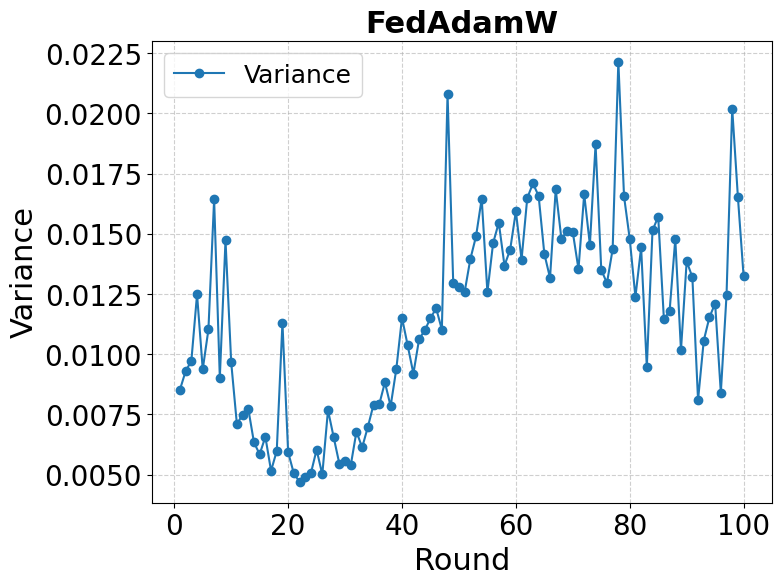

count    100.000000
mean       0.011476
std        0.004055
min        0.004709
25%        0.007914
50%        0.011662
75%        0.014563
max        0.022143
Name: variance, dtype: float64


In [165]:
plot_variance(df_adamw, False, 'FedAdamW')

## FedAvg

In [166]:
df_avg = filter_fed_opt(df, 'FedAvg')
df_avg = df_avg[(df_avg['server_opt_lr_log10'] == 0) & (df_avg['client_opt_lr_log10'] == -3)]

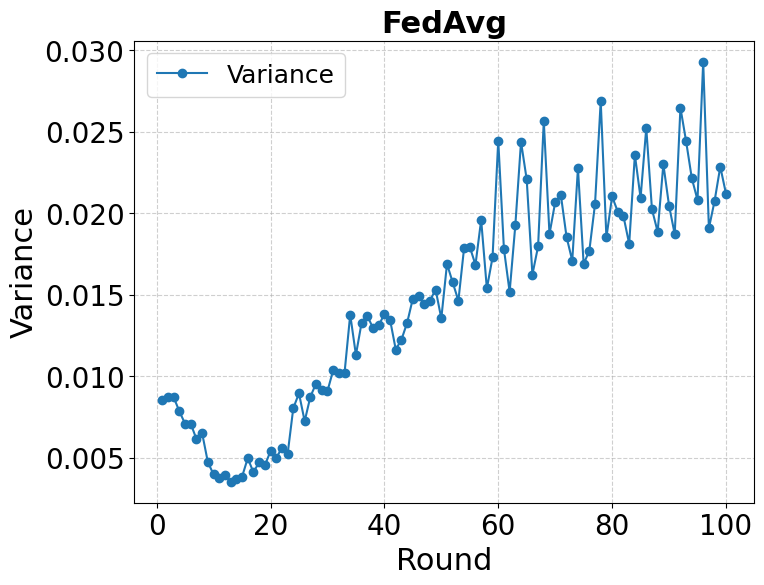

count    100.000000
mean       0.014607
std        0.006671
min        0.003536
25%        0.008749
50%        0.015031
75%        0.019873
max        0.029278
Name: variance, dtype: float64


In [167]:
plot_variance(df_avg, False, 'FedAvg')

## FedAvgM

In [27]:
df_avgm = filter_fed_opt(df, 'FedAvgM', server_opt_momentum=0.9)
df_avgm = df_avgm[(df_avgm['server_opt_lr_log10'] == 0) & (df_avgm['client_opt_lr_log10'] == -4)]

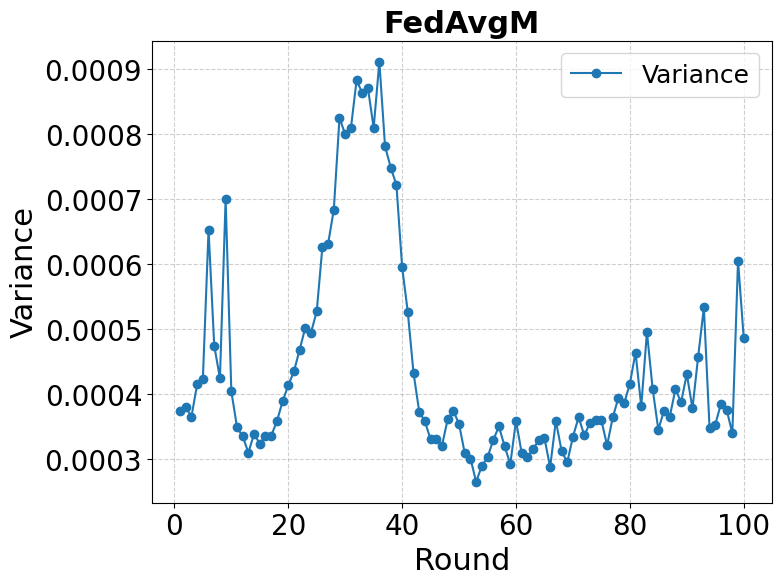

count    100.000000
mean       0.000441
std        0.000162
min        0.000265
25%        0.000336
50%        0.000374
75%        0.000477
max        0.000911
Name: variance, dtype: float64


In [28]:
plot_variance(df_avgm, False, 'FedAvgM')